In [3]:
from BayesianNetwork import *
from ExactInference import *
from ApproximateInference import *
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# global varaibles

T = True
F = False
# Bayes Nets
# AIMA-ALARM example
BN_alarm = BayesNet([
    ('Burglary', [], {
        (): 0.001
    }), ('Earthquake', [], {
        (): 0.002
    }),
    ('Alarm', ['Burglary', 'Earthquake'], {
        (T, T): 0.95,
        (T, F): 0.94,
        (F, T): 0.29,
        (F, F): 0.001
    }), ('JohnCalls', ['Alarm'], {
        (T, ): 0.90,
        (F, ): 0.05
    }), ('MaryCalls', ['Alarm'], {
        (T, ): 0.70,
        (F, ): 0.01
    })
])
# our Bayes Net
BN_horse = BayesNet([
    ('SunnyDay', [], {
        (): 0.7
    }),
    ('RadioOn', [], {
        (): 0.6
    }),
    ('HorseAWins', ['SunnyDay'], {
        (T, ): 0.6,
        (F, ): 0.3
    }),
    ('HorseBWins', ['SunnyDay'], {
        (T, ): 0.8,
        (F, ): 0.3
    }),
    ('JohnCalls', ['HorseAWins', 'HorseBWins'], {
        (T, T): 0.9,
        (T, F): 0.8,
        (F, T): 0.7,
        (F, F): 0.4
    }),
    ('MikeCalls', ['HorseAWins', 'HorseBWins'], {
        (T, T): 0.96,
        (T, F): 0.7,
        (F, T): 0.9,
        (F, F): 0.2
    }),
    ('AlianKnows', ['JohnCalls'], {
        (T, ): 0.9,
        (F, ): 0.2
    }),
    ('LilyKnows', ['MikeCalls', 'RadioOn'], {
        (T, T): 0.95,
        (T, F): 0.8,
        (F, T): 0.5,
        (F, F): 0.1
    })
])
# queries
q_alarm = {
    'causal': {
        'X': 'JohnCalls',
        'e': {
            'Earthquake': F
        }
    },
    'diagnostic': {
        'X': 'Burglary',
        'e': {
            'JohnCalls': T
        }
    },
    'sanity': {
        'X': 'MaryCalls',
        'e': {
            'Alarm': T
        }
    }
}
q_horse = {
    'causal': {
        'X': 'AlianKnows',
        'e': {
            'SunnyDay': T
        }
    },
    'diagnostic': {
        'X': 'HorseBWins',
        'e': {
            'LilyKnows': T
        }
    },
    'sanity': {
        'X': 'LilyKnows',
        'e': {
            'HorseBWins': F,
            'HorseAWins': F
        }
    }
}

In [16]:
def generate_syntax(X, e, bool=True):
    """generate the syntax of a query, e.q. P(SunnyDay=True|AlianKnows=True,LilyKnows=True)"""
    res = "P("
    res += f"{X}=True|" if bool else f"{X}=False|"
    for k, v in e.items():
        res += f"{k}={v},"
    res = res[:-1] + ")"
    return res

In [15]:
def print_res(method, query, p):
    """ print the result of a query"""
    print(f"{method}:")
    print(generate_syntax(query['X'], query['e']) + f" = {round(p[T], 4)}")
    print(generate_syntax(query['X'], query['e'], F) + f" = {round(p[F], 4)}")
    print("------------------")

## Exact Inference

In [6]:
def exact_inference(BN, query):
    """exact inference"""
    # causal reasoning
    causal_q = query['causal']
    p = enumeration_ask(causal_q['X'], causal_q['e'], BN)
    print_res("causal reasoning", causal_q, p)

    # diagnostic reasoning
    diagnostic_q = query['diagnostic']
    p = enumeration_ask(diagnostic_q['X'], diagnostic_q['e'], BN)
    print_res("diagnostic reasoning", diagnostic_q, p)

    # sanity check
    sanity_q = query['sanity']
    p = enumeration_ask(sanity_q['X'], sanity_q['e'], BN)
    print_res("sanity check", sanity_q, p)

In [7]:
exact_inference(BN_alarm, q_alarm)
exact_inference(BN_horse, q_horse)

causal reasoning:
P(JohnCalls=True|Earthquake=False) = 0.0516
P(JohnCalls=False|Earthquake=False) = 0.9484
------------------
diagnostic reasoning:
P(Burglary=True|JohnCalls=True) = 0.0163
P(Burglary=False|JohnCalls=True) = 0.9837
------------------
sanity check:
P(MaryCalls=True|Alarm=True) = 0.7
P(MaryCalls=False|Alarm=True) = 0.3
------------------
causal reasoning:
P(AlianKnows=True|SunnyDay=True) = 0.7488
P(AlianKnows=False|SunnyDay=True) = 0.2512
------------------
diagnostic reasoning:
P(HorseBWins=True|LilyKnows=True) = 0.737
P(HorseBWins=False|LilyKnows=True) = 0.263
------------------
sanity check:
P(LilyKnows=True|HorseBWins=False,HorseAWins=False) = 0.45
P(LilyKnows=False|HorseBWins=False,HorseAWins=False) = 0.55
------------------


## Approximate Inference

In [9]:
def appro_inference(BN, query, rej_sample_size=10000, gibbs_sample_size=300):
    """ approximate inference """
    X = query['X']
    e = query['e']
    p_enum = enumeration_ask(X, e, BN)
    sample = Sample()
    p_rej = sample.rejection_sampling(X, e, BN, rej_sample_size)
    p_gibbs = sample.gibbs_sampling(X, e, BN, gibbs_sample_size)
    print_res("enumeration", query, p_enum)
    print_res("rejection sampling", query, p_rej)
    print_res("gribbs sampling", query, p_gibbs)

In [10]:
appro_inference(BN_alarm, q_alarm['causal'])
appro_inference(BN_alarm, q_alarm['diagnostic'])
appro_inference(BN_alarm, q_alarm['sanity'])
appro_inference(BN_horse, q_horse['causal'])
appro_inference(BN_horse, q_horse['diagnostic'])
appro_inference(BN_horse, q_horse['sanity'])

enumeration:
P(JohnCalls=True|Earthquake=False) = 0.0516
P(JohnCalls=False|Earthquake=False) = 0.9484
------------------
rejection sampling:
P(JohnCalls=True|Earthquake=False) = 0.0453
P(JohnCalls=False|Earthquake=False) = 0.9547
------------------
gribbs sampling:
P(JohnCalls=True|Earthquake=False) = 0.0433
P(JohnCalls=False|Earthquake=False) = 0.9567
------------------
enumeration:
P(Burglary=True|JohnCalls=True) = 0.0163
P(Burglary=False|JohnCalls=True) = 0.9837
------------------
rejection sampling:
P(Burglary=True|JohnCalls=True) = 0.0194
P(Burglary=False|JohnCalls=True) = 0.9806
------------------
gribbs sampling:
P(Burglary=True|JohnCalls=True) = 0.0133
P(Burglary=False|JohnCalls=True) = 0.9867
------------------
enumeration:
P(MaryCalls=True|Alarm=True) = 0.7
P(MaryCalls=False|Alarm=True) = 0.3
------------------
rejection sampling:
P(MaryCalls=True|Alarm=True) = 0.697
P(MaryCalls=False|Alarm=True) = 0.303
------------------
gribbs sampling:
P(MaryCalls=True|Alarm=True) = 0.692

### Convergence test
- How could you define stability?
    - abs(last_p-now_p)/last_p < threshold
- How many samples are needed for rejection sampling to become stable?
- How many samples are needed for Gibbs sampling to become stable?
- Do these values depend on the structure of the network or the query itself?
- Is one algorithm “better” than the other?

In [21]:
def visual(rec_rej,
           rec_gib,
           exact_v,
           title,
           N_rej,
           N_gib,
           x="number of samples",
           y="estimate by sampling"):
    """ plot function including exact and approximate inference """
    plt.plot(rec_rej[0],
             rec_rej[1],
             'r-',
             alpha=0.6,
             label='rejection sampling')
    plt.plot(rec_gib[0], rec_gib[1], 'b-', alpha=0.6, label='gibbs sampling')
    plt.xlim([10, max(N_rej, N_gib)])
    if y == "estimate by sampling":
        plt.ylim([0, 1]) # ylim for convergence plot
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.axhline(y=exact_v, color='g', alpha=0.2, linestyle='dashed', label='exact enumeration')
    plt.legend()
    plt.show()

In [ ]:
# plot the result without convergence test
# sanity_q = q_horse['sanity']
# X = sanity_q['X']
# e = sanity_q['e']

# p = enumeration_ask(X, e, BN_horse)
# conv = {"start_N": 10, "max_N": 10000, "interval": 100, "threshold": 0.01}
# sample = Sample()
# rec_rej = sample.samples(X, e, BN_horse, conv, "rejection")
# rec_gibbs = sample.samples(X, e, BN_horse, conv, "gibbs")
# title = generate_syntax(X, e)
# visual(rec_rej, rec_gibbs, p[T], title, conv)

In [23]:
def test_conv(query, BN, rej_conv, gibbs_conv):
    """ convergence test """
    X = query['X']
    e = query['e']

    sample = Sample()
    start_time1 = datetime.now()
    rec_rej, N_rej, res_rej = sample.converge_sampling(X, e, BN, rej_conv,
                                                       "rejection")
    end_time1 = datetime.now()
    start_time2 = datetime.now()
    rec_gib, N_gib, res_gib = sample.converge_sampling(X, e, BN, gibbs_conv,
                                                       "gibbs")
    end_time2 = datetime.now()
    exact_v = enumeration_ask(X, e, BN)[T]

    print(f"rejection sampling {res_rej}")
    print(
        f"total running time is {(end_time1 - start_time1).total_seconds()*1000} ms"
    )
    print(f"gibbs sampling {res_gib}")
    print(
        f"total running time is {(end_time2 - start_time2).total_seconds()*1000} ms"
    )

    title = generate_syntax(X, e)
    visual(rec_rej, rec_gib, exact_v, title, N_rej, N_gib)

In [24]:
# convergence arguments
rej_conv = {
    "start_N": 10, 
    "max_N": 10000, 
    "interval": 100, 
    "threshold": 0.01
}
gibbs_conv = {
    "start_N": 10,
    "max_N": 10000,
    "interval": 100,
    "threshold": 0.01
}

rejection sampling coverges at N = 1010
total running time is 76.22800000000001 ms
gibbs sampling coverges at N = 910
total running time is 208.444 ms


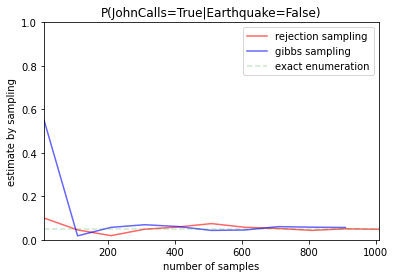

rejection sampling coverges at N = 410
total running time is 10.971 ms
gibbs sampling coverges at N = 1710
total running time is 1020.8600000000001 ms


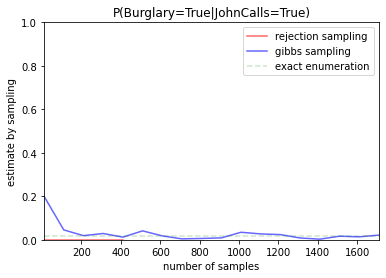

rejection sampling doesn't coverges at max_N = 10000
total running time is 5121.3009999999995 ms
gibbs sampling coverges at N = 2410
total running time is 963.423 ms


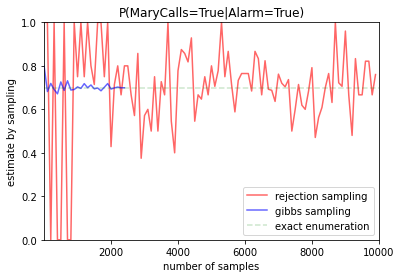

In [25]:
## %%timeit -r5 -n5
# AIAM-ALARM
test_conv(q_alarm['causal'], BN_alarm, rej_conv, gibbs_conv)
test_conv(q_alarm['diagnostic'], BN_alarm, rej_conv, gibbs_conv)
test_conv(q_alarm['sanity'], BN_alarm, rej_conv, gibbs_conv)

rejection sampling coverges at N = 2110
total running time is 491.228 ms
gibbs sampling coverges at N = 6610
total running time is 26486.96 ms


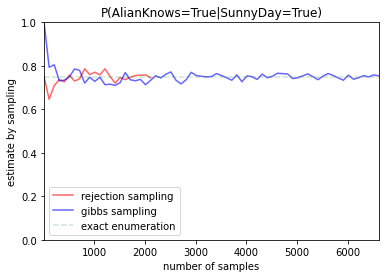

rejection sampling coverges at N = 1110
total running time is 104.727 ms
gibbs sampling coverges at N = 2910
total running time is 6677.053 ms


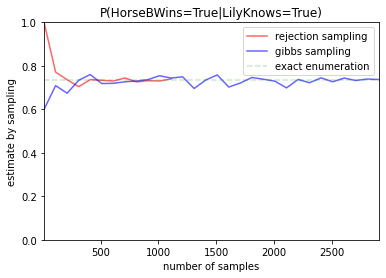

rejection sampling coverges at N = 5910
total running time is 3528.099 ms
gibbs sampling coverges at N = 2310
total running time is 2278.424 ms


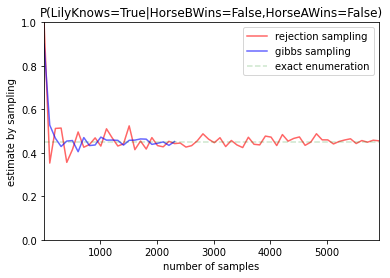

In [26]:
# our example
rej_conv = {
    "start_N": 10, 
    "max_N": 10000, 
    "interval": 100, 
    "threshold": 0.01
}
gibbs_conv = {
    "start_N": 10,
    "max_N": 10000,
    "interval": 100,
    "threshold": 0.01
}
test_conv(q_horse['causal'], BN_horse, rej_conv, gibbs_conv)
test_conv(q_horse['diagnostic'], BN_horse, rej_conv, gibbs_conv)
test_conv(q_horse['sanity'], BN_horse, rej_conv, gibbs_conv)

### Accuracy test

In [28]:
def test_acc(query, BN, rej_conv, gibbs_conv):
    """ accuracy test """
    X = query['X']
    e = query['e']

    exact_v = enumeration_ask(X, e, BN)[T]
    sample = Sample()
    rec_rej, N_rej, res_rej = sample.accuracy_sampling(X, e, BN, rej_conv,
                                                       "rejection")
    rec_gib, N_gib, res_gib = sample.accuracy_sampling(X, e, BN, gibbs_conv,
                                                       "gibbs")
    print(f"rejection sampling {res_rej}")
    print(f"gibbs sampling {res_gib}")

    title = generate_syntax(X, e)
    visual(rec_rej, rec_gib, 0, title, N_rej, N_gib, "number of samples",
           "relative error")  # accuracy

### AIMA

In [29]:
# AIMA-ALARM, threshold: 0.005
rej_conv = {
    "start_N": 10, 
    "max_N": 50000, 
    "interval": 100, 
    "threshold": 0.005
}
gibbs_conv = {
    "start_N": 10,
    "max_N": 50000,
    "interval": 100,
    "threshold": 0.001
}
test_acc(q_alarm['causal'], BN_alarm, rej_conv, gibbs_conv)
test_acc(q_alarm['diagnostic'], BN_alarm, rej_conv, gibbs_conv)
test_acc(q_alarm['sanity'], BN_alarm, rej_conv, gibbs_conv)

rejection sampling achieves zero relative error at N = 1510
gibbs sampling reaches max N = 9910 and fails to achieve zero relative error


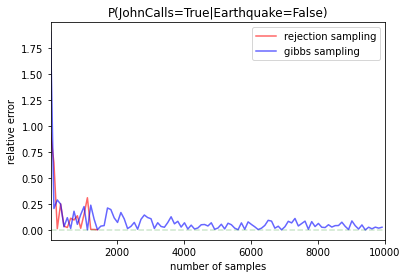

rejection sampling reaches max N = 9910 and fails to achieve zero relative error
gibbs sampling reaches max N = 9910 and fails to achieve zero relative error


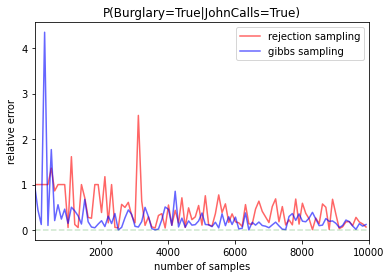

rejection sampling reaches max N = 9910 and fails to achieve zero relative error
gibbs sampling achieves zero relative error at N = 2910


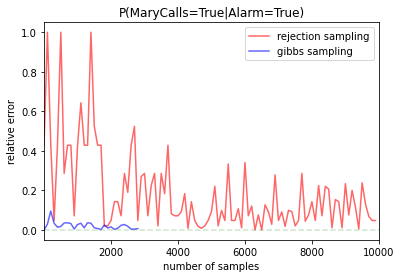

In [ ]:
# AIMA-ALARM, threshold: 0.01
rej_conv = {
    "start_N": 10,
    "max_N": 10000,
    "interval": 100,
    "threshold": 0.01
}
gibbs_conv = {
    "start_N": 10,
    "max_N": 10000,
    "interval": 100,
    "threshold": 0.01
}
test_acc(q_alarm['causal'], BN_alarm, rej_conv, gibbs_conv)
test_acc(q_alarm['diagnostic'], BN_alarm, rej_conv, gibbs_conv)
test_acc(q_alarm['sanity'], BN_alarm, rej_conv, gibbs_conv)

### HORSE

rejection sampling achieves zero relative error at N = 1210
gibbs sampling achieves zero relative error at N = 4210


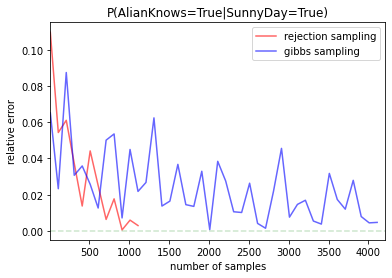

rejection sampling achieves zero relative error at N = 1210
gibbs sampling achieves zero relative error at N = 2710


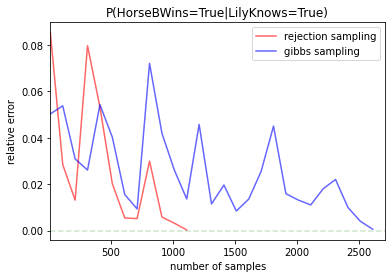

rejection sampling achieves zero relative error at N = 4010
gibbs sampling achieves zero relative error at N = 3510


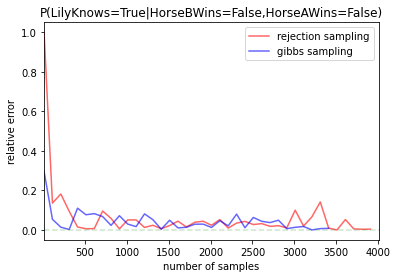

In [11]:
# Our example, threshold: 0.01
rej_conv = {"start_N": 10, "max_N": 10000, "interval": 100, "threshold": 0.01}
gibbs_conv = {
    "start_N": 10,
    "max_N": 10000,
    "interval": 100,
    "threshold": 0.01
}
test_acc(q_horse['causal'], BN_horse, rej_conv, gibbs_conv)
test_acc(q_horse['diagnostic'], BN_horse, rej_conv, gibbs_conv)
test_acc(q_horse['sanity'], BN_horse, rej_conv, gibbs_conv)

rejection sampling achieves zero relative error at N = 3610
gibbs sampling achieves zero relative error at N = 910


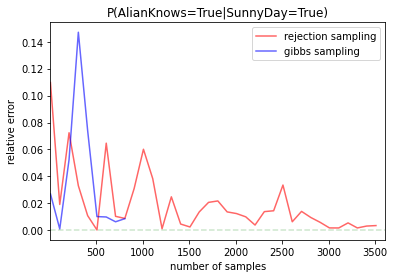

rejection sampling achieves zero relative error at N = 5410
gibbs sampling achieves zero relative error at N = 2510


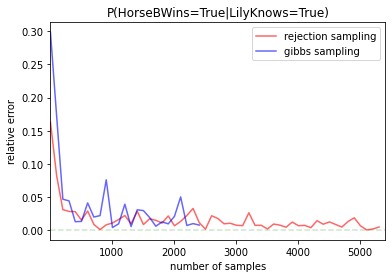

rejection sampling achieves zero relative error at N = 26710
gibbs sampling achieves zero relative error at N = 2810


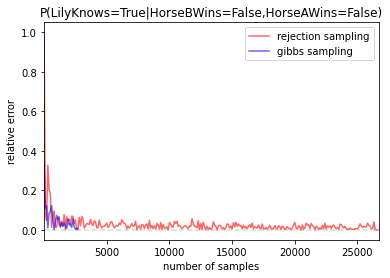

In [12]:
# Our example, threshold: 0.005
rej_conv = {"start_N": 10, "max_N": 50000, "interval": 100, "threshold": 0.005}
gibbs_conv = {
    "start_N": 10,
    "max_N": 50000,
    "interval": 100,
    "threshold": 0.01
}
test_acc(q_horse['causal'], BN_horse, rej_conv, gibbs_conv)
test_acc(q_horse['diagnostic'], BN_horse, rej_conv, gibbs_conv)
test_acc(q_horse['sanity'], BN_horse, rej_conv, gibbs_conv)

In [ ]:
# Our example, threshold: 0.001
rej_conv = {"start_N": 10, "max_N": 50000, "interval": 100, "threshold": 0.001}
gibbs_conv = {
    "start_N": 10,
    "max_N": 50000,
    "interval": 100,
    "threshold": 0.01
}
test_acc(q_horse['causal'], BN_horse, rej_conv, gibbs_conv)
test_acc(q_horse['diagnostic'], BN_horse, rej_conv, gibbs_conv)
test_acc(q_horse['sanity'], BN_horse, rej_conv, gibbs_conv)